## 分布式进程

在Thread和Process中，优先选择process，因为process更稳定。可以分布到多台机器，Thread只能分布到同一台机器的多个CPU上。

Python 的 multiprocessing 模块不但支持多进程，其中 managers 子模块还
支持把多进程分布到多台机器上。

In [4]:
import random, time, queue
from multiprocessing.managers import BaseManager
# 发送任务的队列:
task_queue = queue.Queue()
# 接收结果的队列:
result_queue = queue.Queue()
# 从 BaseManager 继承的 QueueManager:
class QueueManager(BaseManager):
    pass
# 把两个 Queue 都注册到网络上, callable 参数关联了 Queue 对象:
QueueManager.register('get_task_queue', callable=lambda: task_queue)
QueueManager.register('get_result_queue', callable=lambda: 
result_queue)
# 绑定端口 5000, 设置验证码'abc':
manager = QueueManager(address=('', 5000), authkey=b'abc')
# 启动 Queue:
manager.start()
# 获得通过网络访问的 Queue 对象:
task = manager.get_task_queue()
result = manager.get_result_queue()
# 放几个任务进去:
for i in range(10):
    n = random.randint(0, 10000)
    print('Put task %d...' % n)
    task.put(n)
# 从 result 队列读取结果:
print('Try get results...')
for i in range(10):
    r = result.get(timeout=10)
    print('Result: %s' % r)
# 关闭:
manager.shutdown()
print('master exit.')

PicklingError: Can't pickle <function <lambda> at 0x000002408C598158>: attribute lookup <lambda> on __main__ failed

另一台机器启动任务进程

In [3]:
import time, sys, queue
from multiprocessing.managers import BaseManager
# 创建类似的 QueueManager:
class QueueManager(BaseManager):
    pass
# 由于这个 QueueManager 只从网络上获取 Queue，所以注册时只提供名字:
QueueManager.register('get_task_queue')
QueueManager.register('get_result_queue')
# 连接到服务器，也就是运行 task_master.py 的机器:
server_addr = '127.0.0.1'
print('Connect to server %s...' % server_addr)
# 端口和验证码注意保持与 task_master.py 设置的完全一致:
m = QueueManager(address=(server_addr, 5000), authkey=b'abc')
# 从网络连接:
m.connect()
# 获取 Queue 的对象:
task = m.get_task_queue()
result = m.get_result_queue()
# 从 task 队列取任务,并把结果写入 result 队列:
for i in range(10):
    try:
        n = task.get(timeout=1)
        print('run task %d * %d...' % (n, n))
        r = '%d * %d = %d' % (n, n, n*n)
        time.sleep(1)
        result.put(r)
    except Queue.Empty:
        print('task queue is empty.')
# 处理结束:
print('worker exit.')

Connect to server 127.0.0.1...


ConnectionRefusedError: [WinError 10061] 由于目标计算机积极拒绝，无法连接。

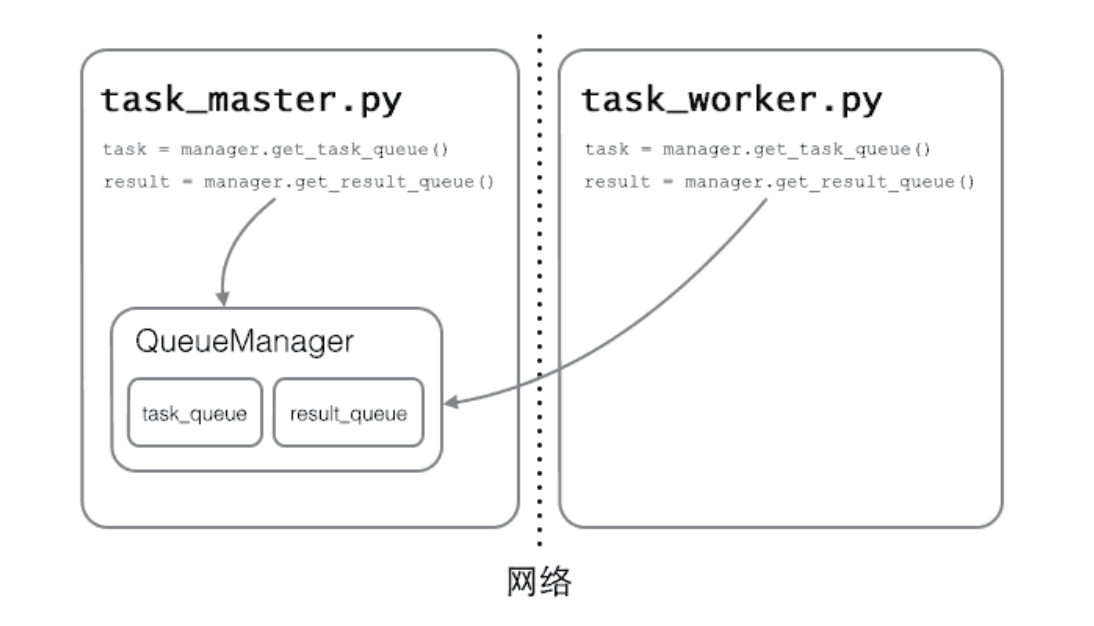